# Link prediction with GraphSAGE

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as StellarGraph
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator ,HinSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [2]:
Dr_emb = pd.read_csv('drug_vector_d100.csv')
Dr_name = pd.read_csv('drugn.csv')
Dr_emb.index=Dr_name['id']
Pro_emb = pd.read_csv('protein_vector_d400.csv')
Pro_name = pd.read_csv('protn.csv')
Pro_emb.index=Pro_name['id']

In [3]:
DTI=pd.read_csv('dtinew.csv')
DTI
#DTI.dropna()

,source,target,orientation
0,r1,p113,430
1,r1,p76,634
2,r10,p367,706
3,r10,p65,706
4,r100,p146,156
...,...,...,...
1918,r98,p11,80
1919,r98,p120,80
1920,r98,p151,80
1921,r98,p575,130


In [4]:
from stellargraph import StellarGraph
G= StellarGraph({"Drug": Dr_emb, "Protein": Pro_emb},{'Disease':DTI})

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2201, Edges: 1923

 Node types:
  Protein: [1493]
    Features: float32 vector, length 400
    Edge types: Protein-Disease->Drug
  Drug: [708]
    Features: float32 vector, length 100
    Edge types: Drug-Disease->Protein

 Edge types:
    Drug-Disease->Protein: [1923]
        Weights: all 1 (default)
        Features: float32 vector, length 1


In [6]:
from stellargraph.data import EdgeSplitter

# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.2, method="global", edge_label="Disease"
)

print(graph_test.info())

Network has 1923 edges of type Disease
Network has 1923 edges of type Disease
** Sampled 384 positive and 384 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2201, Edges: 1539

 Node types:
  Protein: [1493]
    Features: float32 vector, length 400
    Edge types: Protein-Disease->Drug
  Drug: [708]
    Features: float32 vector, length 100
    Edge types: Drug-Disease->Protein

 Edge types:
    Drug-Disease->Protein: [1539]
        Weights: all 1 (default)
        Features: none


In [7]:
from sklearn.model_selection import train_test_split

# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, G)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.2, method="global", edge_label="Disease"
)
(
    edges_train,
    edges_test,
    labels_train,
    labels_test,
) = train_test_split(examples, labels, train_size=0.8, test_size=0.2)

print(graph_train.info())

Network has 1539 edges of type Disease
Network has 1539 edges of type Disease
** Sampled 307 positive and 307 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2201, Edges: 1232

 Node types:
  Protein: [1493]
    Features: float32 vector, length 400
    Edge types: Protein-Disease->Drug
  Drug: [708]
    Features: float32 vector, length 100
    Edge types: Drug-Disease->Protein

 Edge types:
    Drug-Disease->Protein: [1232]
        Weights: all 1 (default)
        Features: none


In [8]:
edgelist_train = list(edges_train)
edgelist_test = list(edges_test)

In [9]:
batch_size = 20
epochs = 50

In [10]:
num_samples = [8,4]

In [12]:
#Change the place of protein and drug if an error happend
generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["Protein", "Drug"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

In [13]:
hinsage_layer_sizes = [16, 16]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.1,normalize='l2'
)

In [14]:
x_inp, x_out = hinsage.in_out_tensors()

In [15]:
prediction = link_classification(output_dim=1, output_act="relu", edge_embedding_method="ip")(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [16]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.AUC(),keras.metrics.AUC(curve='PR')],
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 100)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 400)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 100)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 400)]     0                                            
______________________________________________________________________________________________

In [18]:
num_workers = 4

In [19]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

7/7 [==============================] - 1s 18ms/step - loss: 3.4317 - auc: 0.4317 - auc_1: 0.4216
Untrained model's Test Evaluation:
	loss: 3.4317
	auc: 0.4317
	auc_1: 0.4216


In [20]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)


Epoch 1/50
25/25 [==============================] - 4s 39ms/step - loss: 2.8081 - auc: 0.4466 - auc_1: 0.4547 - val_loss: 1.2230 - val_auc: 0.6161 - val_auc_1: 0.6005
Epoch 2/50
25/25 [==============================] - 1s 32ms/step - loss: 1.1900 - auc: 0.6265 - auc_1: 0.6140 - val_loss: 0.8624 - val_auc: 0.6902 - val_auc_1: 0.7002
Epoch 3/50
25/25 [==============================] - 1s 34ms/step - loss: 0.8036 - auc: 0.7103 - auc_1: 0.7091 - val_loss: 0.7238 - val_auc: 0.7337 - val_auc_1: 0.7307
Epoch 4/50
25/25 [==============================] - 1s 33ms/step - loss: 0.6747 - auc: 0.7764 - auc_1: 0.7582 - val_loss: 0.5637 - val_auc: 0.7753 - val_auc_1: 0.7609
Epoch 5/50
25/25 [==============================] - 1s 34ms/step - loss: 0.5154 - auc: 0.8363 - auc_1: 0.8143 - val_loss: 0.5245 - val_auc: 0.8241 - val_auc_1: 0.8072
Epoch 6/50
25/25 [==============================] - 1s 33ms/step - loss: 0.5001 - auc: 0.8789 - auc_1: 0.8712 - val_loss: 0.4922 - val_auc: 0.8505 - val_auc_1: 0.805

Epoch 50/50
25/25 [==============================] - 1s 32ms/step - loss: 0.1021 - auc: 0.9989 - auc_1: 0.9988 - val_loss: 0.2599 - val_auc: 0.9533 - val_auc_1: 0.9430


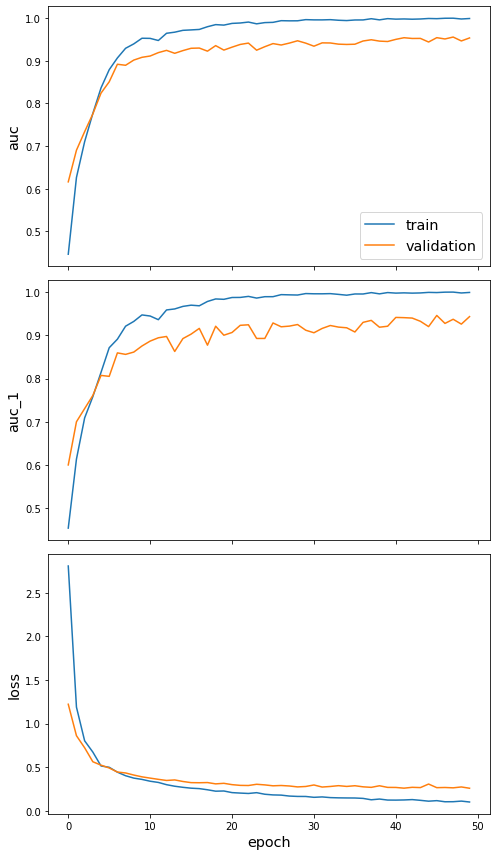

In [21]:
sg.utils.plot_history(history)

In [22]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

7/7 [==============================] - 0s 20ms/step - loss: 0.2643 - auc: 0.9460 - auc_1: 0.9246
Test Evaluation:
	loss: 0.2643
	auc: 0.9460
	auc_1: 0.9246


In [23]:
train_metrics = model.evaluate(train_gen)
test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

7/7 [==============================] - 0s 15ms/step - loss: 0.2624 - auc: 0.9530 - auc_1: 0.9380

Train Set Metrics of the trained model:
	loss: 0.0733
	auc: 0.9997
	auc_1: 0.9997

Test Set Metrics of the trained model:
	loss: 0.2624
	auc: 0.9530
	auc_1: 0.9380


In [24]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  0.49985125687607806
	mean_absolute_error =  0.49970255828485255

Model Test set metrics:
	root_mean_square_error =  0.2920759440753166
	mean_absolute_error =  0.16090472939053202
